**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**October, 2023**

---

# Malaria-infected vs uninfected matched explants (d1) single cell

In [1]:
library(limma)
library(scuttle)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)
library(Seurat)
library(edgeR)
library(reshape2)
library(magrittr)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

In [19]:
anndata <- readRDS('../../../../data_integration/48h/results/scVI/malaria_singleCell_48h.rds')
anndata

An object of class Seurat 
36601 features across 2719 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

In [20]:
Idents(anndata)= anndata$cell_type

In [21]:
head(Idents(anndata))

Pla_HDBR13661567_AAACCCACAGCTACCG Pla_HDBR13661567_AAACCCACAGCTTCGG 
                           Endo_f                            Endo_f 
Pla_HDBR13661567_AAACCCAGTGCCTGCA Pla_HDBR13661567_AAACGAAGTGACCGAA 
                           Endo_f                           VCT_CCC 
Pla_HDBR13661567_AAACGCTCAAACACCT Pla_HDBR13661567_AAAGAACGTATAATGG 
                           Endo_f                            Endo_f 
13 Levels: EVT_1 EVT_2 Endo_f F F_p HBC PAMM1 PV VCT VCT_CCC ... iEVT

# Macrophages

In [22]:
Mos= subset(x = anndata, idents = c("HBC","PAMM1"))

Idents(object = Mos) <- "infection"


#fixxing levels
Mos$celltype.Stage = factor(Mos$celltype.Stage, levels = c("HBC-Pf_48h", "HBC-UI_Pf_48h", "PAMM1-Pf_48h","PAMM1-UI_Pf_48h"))
Mos$cell_type<- factor(Mos$cell_type, levels = c("HBC","PAMM1"))

#The levels for the infection should follow this order to ensure that positive Fold changes correspond to increases in infection
Mos$infection<- factor(Mos$infection, levels = c("UI","Pf"))

In [23]:
Mos$classification = paste(Mos$cell_type, Mos$infection, sep='-') # split celltype by disease status


# estimate % cells expressing a gene in each class
plot <- DotPlot(object = Mos, features = rownames(Mos), group.by = 'classification')
plot$data$value = plot$data$pct.exp
percent_mat = acast(plot$data, features.plot ~ id)

In [24]:
head(percent_mat)

,HBC-Pf,HBC-UI,PAMM1-Pf,PAMM1-UI
AC115284.3,0.00000,0.000000,0.00000,0.000000
RNF186,0.00000,0.000000,0.00000,0.000000
FMR1,33.33333,50.000000,47.61905,40.340909
CANX,100.00000,94.444444,100.00000,96.022727
ZNF84-DT,0.00000,2.777778,0.00000,0.000000
LIPA,33.33333,41.666667,9.52381,8.522727


In [25]:
#print(Idents(VCT_fusing))

In [26]:
table(Mos[["celltype.Stage"]] )


     HBC-Pf_48h   HBC-UI_Pf_48h    PAMM1-Pf_48h PAMM1-UI_Pf_48h 
              3              36              42             176 

In [27]:
anndata_sce <- as.SingleCellExperiment(Mos)

In [28]:
anndata_sce

class: SingleCellExperiment 
dim: 36601 257 
metadata(0):
assays(2): counts logcounts
rownames(36601): AC115284.3 RNF186 ... PODNL1 LINC01737
rowData names(0):
colnames(257): Pla_HDBR13661567_AACCATGCAAATTAGG
  Pla_HDBR13661567_AACCATGCACCGGCTA ...
  Pla_HDBR13661574_TGGCGTGAGTTCCAGT Pla_HDBR13661574_TTCATGTTCTGAGAGG
colData names(11): infection donor_id ... classification ident
reducedDimNames(0):
altExpNames(0):

### Prepare the pseudobulk count matrix:

In [29]:
# generate 3 metacells for each donor-celltype combination
n=3
anndata_sce$random_seed = sample(1:n, size = ncol(anndata_sce), replace = T)
anndata_sce$metacell_id = paste( colData(anndata_sce)$infection, 
                                colData(anndata_sce)$cell_type, 
                                colData(anndata_sce)$donor_id, 
                                colData(anndata_sce)$random_seed, 
                                sep='-')
## aggregateAcrossCells here it is only aggregated by celltype, genotype and random group
summed <- aggregateAcrossCells(anndata_sce, id=colData(anndata_sce)[,c("metacell_id")])

##have a look at the counts
counts(summed)[1:3,]


#have a look at the colData of our new object summed, can you see Group and 
# metacell_id are there
# colData(summed)
table(summed$classification)
table(summed$infection)

,Pf-HBC-Hrv232-2,Pf-HBC-Hrv236-2,Pf-PAMM1-Hrv232-1,Pf-PAMM1-Hrv232-2,Pf-PAMM1-Hrv232-3,Pf-PAMM1-Hrv236-1,Pf-PAMM1-Hrv236-2,Pf-PAMM1-Hrv236-3,UI-HBC-Hrv232-1,UI-HBC-Hrv232-2,UI-HBC-Hrv232-3,UI-HBC-Hrv236-1,UI-PAMM1-Hrv232-1,UI-PAMM1-Hrv232-2,UI-PAMM1-Hrv232-3,UI-PAMM1-Hrv236-1,UI-PAMM1-Hrv236-2,UI-PAMM1-Hrv236-3
AC115284.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
RNF186,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FMR1,0,1,11,12,3,5,1,3,10,16,4,2,40,29,31,1,2,2



  HBC-Pf   HBC-UI PAMM1-Pf PAMM1-UI 
       2        4        6        6 


UI Pf 
10  8 

In [30]:
summed

class: SingleCellExperiment 
dim: 36601 18 
metadata(0):
assays(1): counts
rownames(36601): AC115284.3 RNF186 ... PODNL1 LINC01737
rowData names(0):
colnames(18): Pf-HBC-Hrv232-2 Pf-HBC-Hrv236-2 ... UI-PAMM1-Hrv236-2
  UI-PAMM1-Hrv236-3
colData names(15): infection donor_id ... ids ncells
reducedDimNames(0):
altExpNames(0):

In [31]:
summed$infection<- factor(summed$infection, levels = c( "UI","Pf"))

In [32]:
table(summed$infection)


UI Pf 
10  8 

### Corrected by genotype

In [33]:
DEGs_list = list()

In [34]:
for (celltypeOf_interest in unique(summed$cell_type) ){
    
    #celltypeOf_interest = 'VCT'
    print(celltypeOf_interest)

    # (0) Subset to celltype
    summed_celltype = subset(summed, , summed$cell_type == celltypeOf_interest)


    # (1) Generate a DGEList object to use as input for limma and filter the genes to remove lowly expressed genes. How many are left?
    #As in the standard limma analysis generate a DGE object
    y <- DGEList(counts(summed_celltype), samples=colData(summed_celltype)$metacell_id)

    ##filter lowly expressed (recommended for limma)
    #     keep <- filterByExpr(y, group=summed_celltype$dataset, min.total.count = 3000, min.prop = 0.1)
    keep <- filterByExpr(y, group=summed_celltype$donor_id, min.prop = 0.2)

    genes20percent = rownames(percent_mat)[ apply(percent_mat[, unique(summed_celltype$classification) ], 1, max) > 20 ] # get genes with > 20% expressed cells in the celltypeOf_interest
    keep <- keep & names(keep) %in% genes20percent
    y <- y[ keep ,]



    # (2) Perform TMM normalization using edgeR, and then limma can perform the transformation with voom, fit the model, compute the contrasts and compute test statistics with eBayes:
    y <- edgeR::calcNormFactors(y)


    ##see how many genes were kept 
    summary(keep)


    # (3) Generate a design matrix, including dataset to model for a paired analysis. 
    # If you need help to generate a design matrix, check out the very nice edgeR User Guide, sections 3.3 and 3.4. 
    ## Create the design matrix for paired samples while correcting for the effect of the donor to obtain
    #  the overall effect of the infection across donors:
    design <- model.matrix(~summed_celltype$donor_id+summed_celltype$infection)
        # stimate dispersion
    y <- estimateDisp(y,design)
        # Have a look
    head(design)


    # (4) Do limma DEG
    fit <- glmQLFit(y, design)
    qlf <- glmQLFTest(fit)
    topTags(qlf)

    ##  Adjust P values using bonferroni and BH
    limma_de = qlf$table
    limma_de$bonferroni = p.adjust(limma_de$PValue, "bonferroni")
    limma_de$p_val_adj = p.adjust(limma_de$PValue, "BH")
        
    # order table by P-value
    limma_de= limma_de[ order(limma_de$p_val_adj, decreasing = FALSE), ]
    #limma_de <- order(limma_de$p.adjust, decreasing = FALSE)
    #imma_de = limma_de.sort_values('p.adjust', ascending = TRUE)

    # Adding to the list
    DEGs_list[[celltypeOf_interest]] = limma_de
} 

[1] "HBC"
[1] "PAMM1"


In [35]:
##  Saving the DEG matrix

write.table(DEGs_list[["HBC"]],'../results/SC_limma_Immune_MAL_48h/1_DEGs_SC_MAL_48h_HBC.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)
write.table(DEGs_list[["PAMM1"]],'../results/SC_limma_Immune_MAL_48h/2_DEGs_SC_MAL_48h_PAMM1.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)

In [36]:
#colData(summed_celltype)$metacell_id

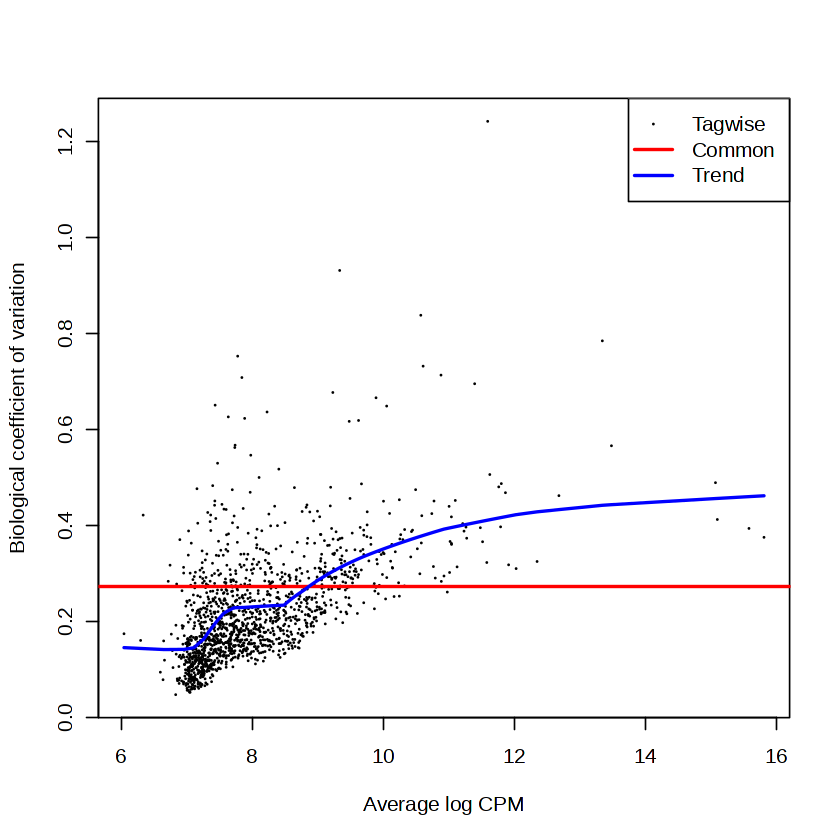

In [37]:
plotBCV(y)

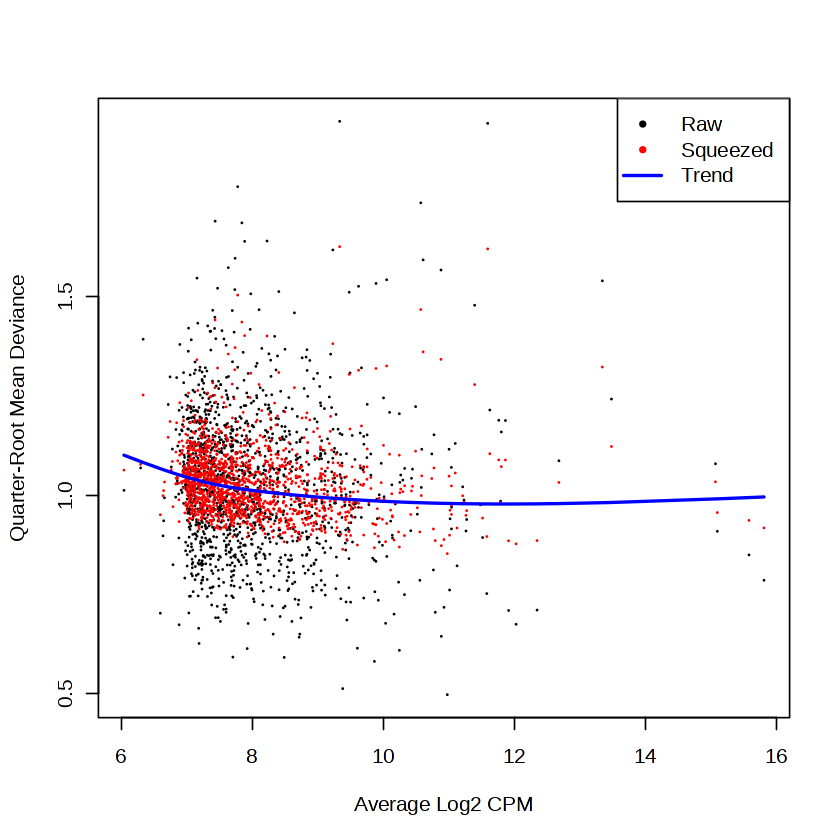

In [38]:
plotQLDisp(fit)

In [39]:
o <- order(qlf$table$PValue)
cpm(y)[o[1:20],]

,Pf-PAMM1-Hrv232-1,Pf-PAMM1-Hrv232-2,Pf-PAMM1-Hrv232-3,Pf-PAMM1-Hrv236-1,Pf-PAMM1-Hrv236-2,Pf-PAMM1-Hrv236-3,UI-PAMM1-Hrv232-1,UI-PAMM1-Hrv232-2,UI-PAMM1-Hrv232-3,UI-PAMM1-Hrv236-1,UI-PAMM1-Hrv236-2,UI-PAMM1-Hrv236-3
ADM,204.11401,261.09939,178.97846,247.15870,344.99083,735.30094,117.37348,99.09783,89.48522,130.56250,298.02078,172.42079
PARP14,147.90870,138.22909,55.93077,58.15499,86.24771,66.84554,200.81869,232.61913,172.57864,304.64583,198.68052,295.57850
ISG15,171.57410,138.22909,67.11692,130.84872,201.24465,40.10732,530.01461,400.56388,333.28679,43.52083,49.67013,98.52617
NIBAN1,502.88959,287.97727,413.88770,87.23248,57.49847,347.59681,192.56586,195.06626,122.35734,130.56250,0.00000,197.05233
BTG3,360.89724,345.57272,447.44616,567.01112,402.48930,695.19361,276.92805,302.50918,255.67206,261.12500,248.35065,295.57850
DOCK8,337.23184,195.82454,123.04769,174.46496,28.74924,66.84554,324.61103,347.36399,339.67859,304.64583,596.04155,418.73620
VPS13C,76.91253,134.38939,33.55846,101.77123,57.49847,80.21465,125.62630,151.25459,162.53438,174.08333,149.01039,197.05233
SAMSN1,106.49427,245.74060,67.11692,116.30997,517.48624,334.22770,258.58845,361.96788,286.71795,174.08333,1192.08310,640.42007
IFITM3,47.33079,69.11454,33.55846,130.84872,114.99694,133.69108,190.73190,126.21935,146.09832,130.56250,0.00000,24.63154
TET2,94.66157,119.03060,89.48923,87.23248,143.74618,120.32197,153.13571,163.77221,155.22946,391.68749,99.34026,147.78925


In [40]:
summary(decideTests(qlf))

       summed_celltype$infectionPf
Down                             0
NotSig                        1423
Up                               0

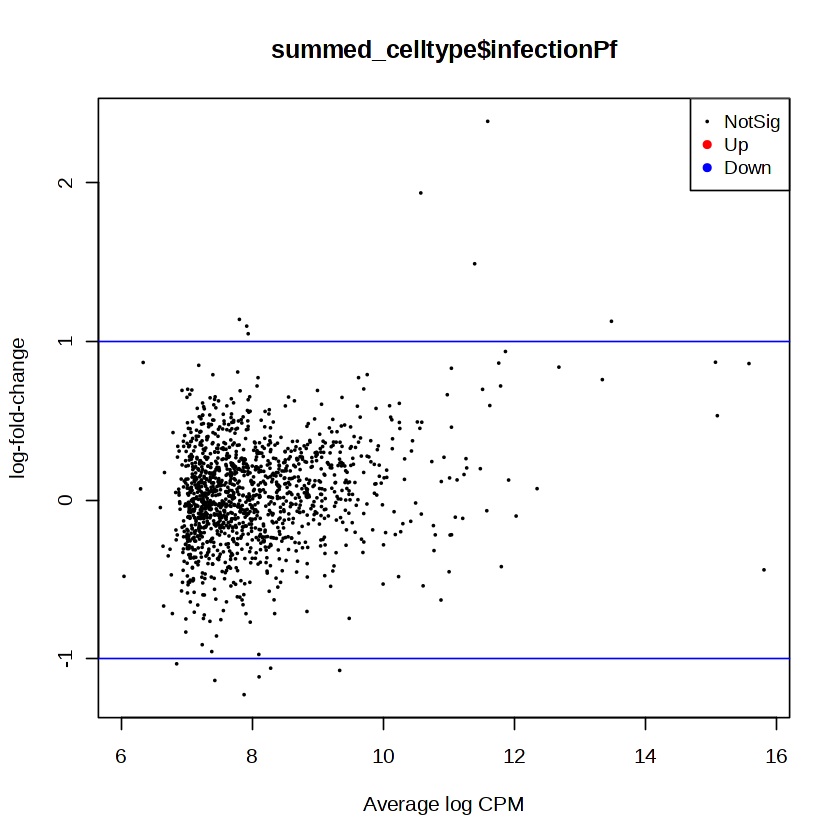

In [41]:
plotMD(qlf)
abline(h=c(-1, 1), col="blue")

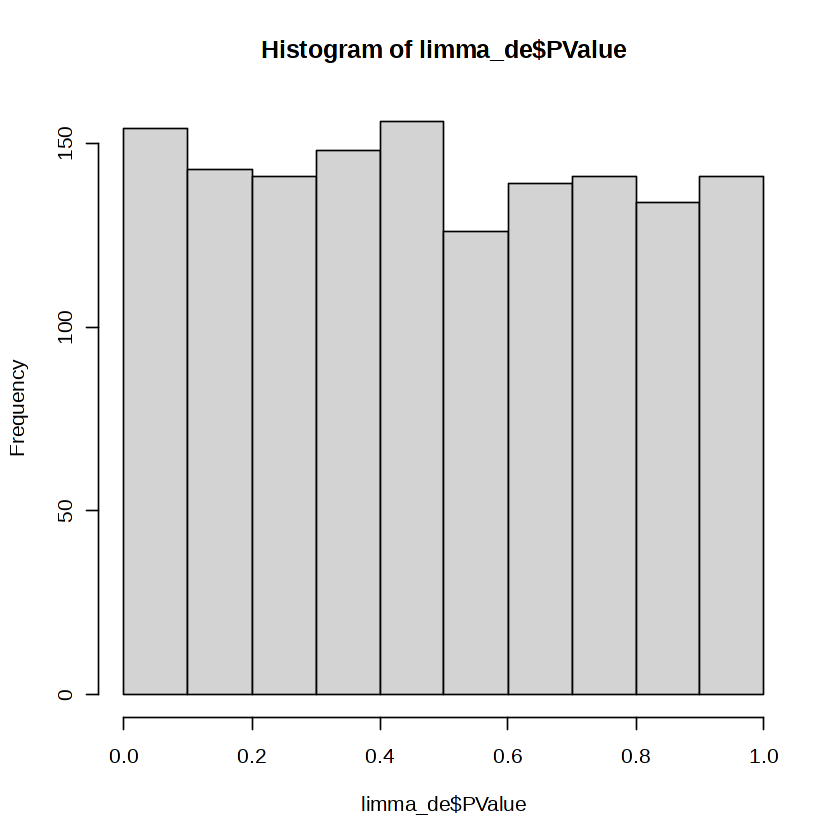

In [42]:
limma_de = qlf$table
limma_de$bonferroni = p.adjust(limma_de$PValue, "bonferroni")
limma_de$BH = p.adjust(limma_de$PValue, "BH")

hist(limma_de$PValue)

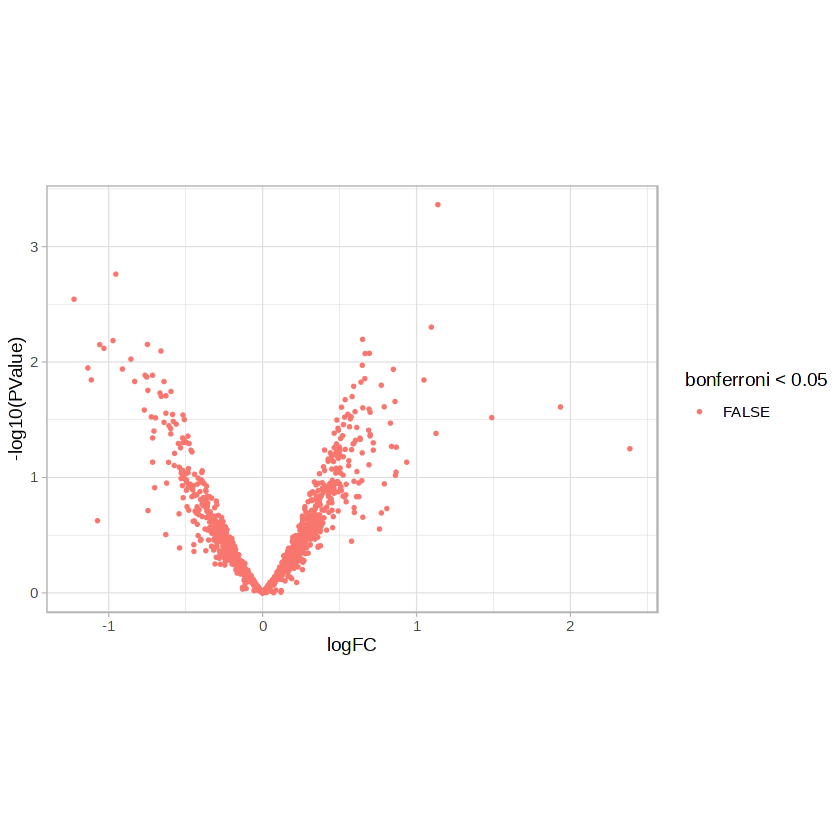

In [43]:
library(ggplot2, warn.conflicts = FALSE)
ggplot(limma_de, aes(x = logFC, y = - log10(PValue))) +
  geom_point(aes(color = bonferroni < 0.05), size = 0.5) + 
    theme_light()  + 
    coord_fixed(ratio = 0.75)

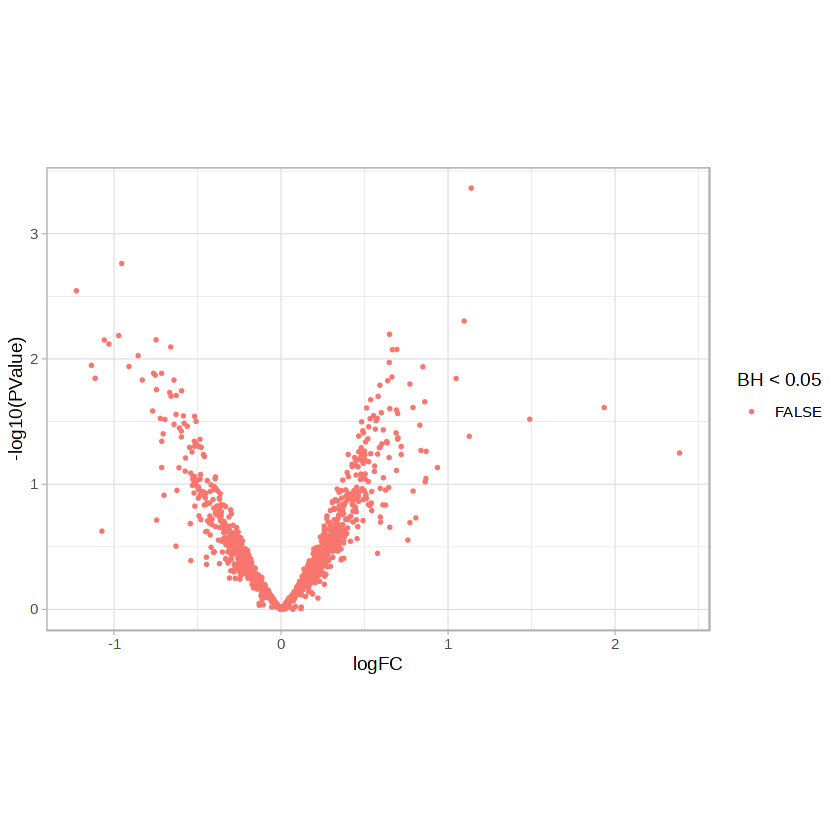

In [44]:
ggplot(limma_de, aes(x = logFC, y = - log10(PValue))) +
  geom_point(aes(color = BH < 0.05), size = 0.5) + 
    theme_light()  + 
    coord_fixed(ratio = 0.75)

In [2]:
sessionInfo()

R version 4.0.4 (2021-02-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] magrittr_2.0.3              reshape2_1.4.4             
 [3] edgeR_3.32.1                SeuratObject_4.0.0         
 [5] Seurat_4.0.1                patchwork_1.1.1            
 [7] dplyr_1.0.5                 scran_1.18.5               
